# TEST DATA 

In [1]:
import numpy as np 
from glob import glob 
from os.path import join
import torch 
from utils import *
from pymatreader import read_mat
from matplotlib import pyplot as plt 

In [2]:
node_ordering = read_mat('newnode_order_3.mat')['node_order'] - 1 # For MATLAB to Python indexing, there is -1
node_ordering

array([  1,   0,   2,   4,   5, 187, 192,   3,   6,   7,   9,  10,  11,
       177, 183, 188, 193, 194, 195,   8,  13,  14, 165, 171,  12,  19,
        20,  21, 159, 160, 166, 172,  18,  17,  25,  16,  24,  26,  27,
        32,  33,  34,  15,  22,  23, 199, 204,  29,  30,  31, 198, 203,
       210, 211,  38,  39,  48, 218,  40,  49,  54,  55, 217, 223, 224,
       229,  41,  42,  50,  51,  43,  52,  56,  57,  58,  59,  35,  36,
        44,  28,  37,  45,  53, 135,  46,  47, 137, 142, 128, 129, 130,
       136, 138, 143, 147, 148,  61,  60,  68,  69, 127,  67,  75,  76,
        77, 119,  66,  65,  73,  74,  64,  72,  81,  82,  83,  63,  62,
        70,  71,  78,  79, 233, 236,  80,  87,  90,  91,  86,  89,  92,
        88, 239, 482, 488, 238, 447, 478, 481, 485, 487, 489, 237, 235,
       440, 446, 231, 232, 234, 439, 445, 453, 480, 227, 222, 226, 228,
       230, 216, 221, 225, 432, 434, 435, 209, 202, 208, 215, 197, 201,
       207, 214, 220, 196, 189, 190, 200, 184, 185, 186, 191, 20

### This cell is JUST for the geometries that have geometric variation, and the node reordering is already conducted in MATLAB. So, there is no need to use reordering on the A matrix again, it is for reordering the original data every time a list of test dictionary is created. The test data regarding the original geometry is in the [test_dictionary__.pt](test_dictionary__.pt)

In [3]:
## Get the files from the geometric variation folder 
HT_files = glob(join("GeometricVariation","GeometricModels","*HT*"))
HLT_files = glob(join("GeometricVariation","GeometricModels","*HLT*"))
HT_files, HLT_files

(['GeometricVariation\\GeometricModels\\AlreadyReordered_HT_x_-37.mat',
  'GeometricVariation\\GeometricModels\\AlreadyReordered_HT_y_-7.mat',
  'GeometricVariation\\GeometricModels\\AlreadyReordered_HT_z_21.mat',
  'GeometricVariation\\GeometricModels\\AlreadyReordered_HT__.mat'],
 ['GeometricVariation\\GeometricModels\\AlreadyReordered_HLT_x_-37.mat',
  'GeometricVariation\\GeometricModels\\AlreadyReordered_HLT_y_-7.mat',
  'GeometricVariation\\GeometricModels\\AlreadyReordered_HLT_z_21.mat',
  'GeometricVariation\\GeometricModels\\AlreadyReordered_HLT__.mat'])

In [4]:
test_data_location = join("D:\BayesianECGI\Bayesian\TestData","EP")
test_files = glob(join(test_data_location,"*.mat"))
test_files

['D:\\BayesianECGI\\Bayesian\\TestData\\EP\\qrs_21jun01_12.mat',
 'D:\\BayesianECGI\\Bayesian\\TestData\\EP\\qrs_21jun01_3.mat',
 'D:\\BayesianECGI\\Bayesian\\TestData\\EP\\qrs_21jun01_4.mat',
 'D:\\BayesianECGI\\Bayesian\\TestData\\EP\\qrs_8oct02_31.mat',
 'D:\\BayesianECGI\\Bayesian\\TestData\\EP\\qrs_8oct02_32.mat',
 'D:\\BayesianECGI\\Bayesian\\TestData\\EP\\rsm131200_13qrs.mat',
 'D:\\BayesianECGI\\Bayesian\\TestData\\EP\\rsm8oct02_0055_qrs.mat',
 'D:\\BayesianECGI\\Bayesian\\TestData\\EP\\rsm8oct02_0056_qrs.mat',
 'D:\\BayesianECGI\\Bayesian\\TestData\\EP\\rsm8oct02_0066_qrs.mat',
 'D:\\BayesianECGI\\Bayesian\\TestData\\EP\\rsm8oct02_0082_qrs.mat',
 'D:\\BayesianECGI\\Bayesian\\TestData\\EP\\rsm8oct02_0086_qrs.mat',
 'D:\\BayesianECGI\\Bayesian\\TestData\\EP\\rsm8oct02_0090_qrs.mat',
 'D:\\BayesianECGI\\Bayesian\\TestData\\EP\\rsm8oct02_0120_qrs.mat',
 'D:\\BayesianECGI\\Bayesian\\TestData\\EP\\rsm8oct02_0123_qrs.mat',
 'D:\\BayesianECGI\\Bayesian\\TestData\\EP\\rsm8oct02_0130_qr

In [5]:
noise_prm = 30
for HLT_file, HT_file in zip(HLT_files,HT_files):

        A_HLT = read_mat(HLT_file)["Trf_HLT_coarse"]
        A_HT = read_mat(HT_file)["Trf_HT_coarse"]
        
        direction = HLT_file.split("_")[2]
        angle = HLT_file.split("_")[-1].split(".")[0]
        
        X_test = np.empty((490,1))
        Y_test = np.empty((192,1))
        AT_test = np.empty((490,1))
        intervals = []
        
        test_data_container = []
        test_data_counter = np.array([])
        for i,file in enumerate(test_files):
            data_container = {} 
            data = read_mat(file)
            QRS = data["ep"]["potvals"][node_ordering,:]
            time_frames = QRS.shape[-1]
            at = data["ep"]["at"]
            noise_free_torso = A_HLT.dot(QRS)
            noisy_torso, N, std_noise = add_noise(noise_free_torso,noise_prm)
            # assert np.max(at)<=interval, (print(np.max(at), interval) and False) or "AT out of QRS!"
            X_test = np.hstack((X_test,QRS))
            AT_test = np.hstack((AT_test,np.expand_dims(at,1)))
            data_container['inverse_matrix'] = A_HT
            data_container['x'] = torch.from_numpy(QRS)
            data_container['y'] = torch.from_numpy(noisy_torso)
            data_container['badleads'] = torch.from_numpy(np.where(np.in1d(node_ordering,data['ep']['badleads']-1))[0]) # -1 Due to MATLAB ordering
            data_container['std_n'] = std_noise
            data_container['at'] = at[node_ordering]
            data_container['paceloc'] = torch.from_numpy(np.where(np.in1d(node_ordering,data['ep']['pacing']))[0]) 
            test_data_container.append(data_container)    
        X_test = X_test[:,1:]
        AT_test = AT_test[:,1:]
        Y_test = A_HLT.dot(X_test)
        torch.save(test_data_container,join("Test_Dictionaries","test_dictionary_" + direction + "_" + str(angle) + "_Noise" + str(noise_prm) + ".pt"))
    

Below code is just for visualization

(-15.0, 15.0)

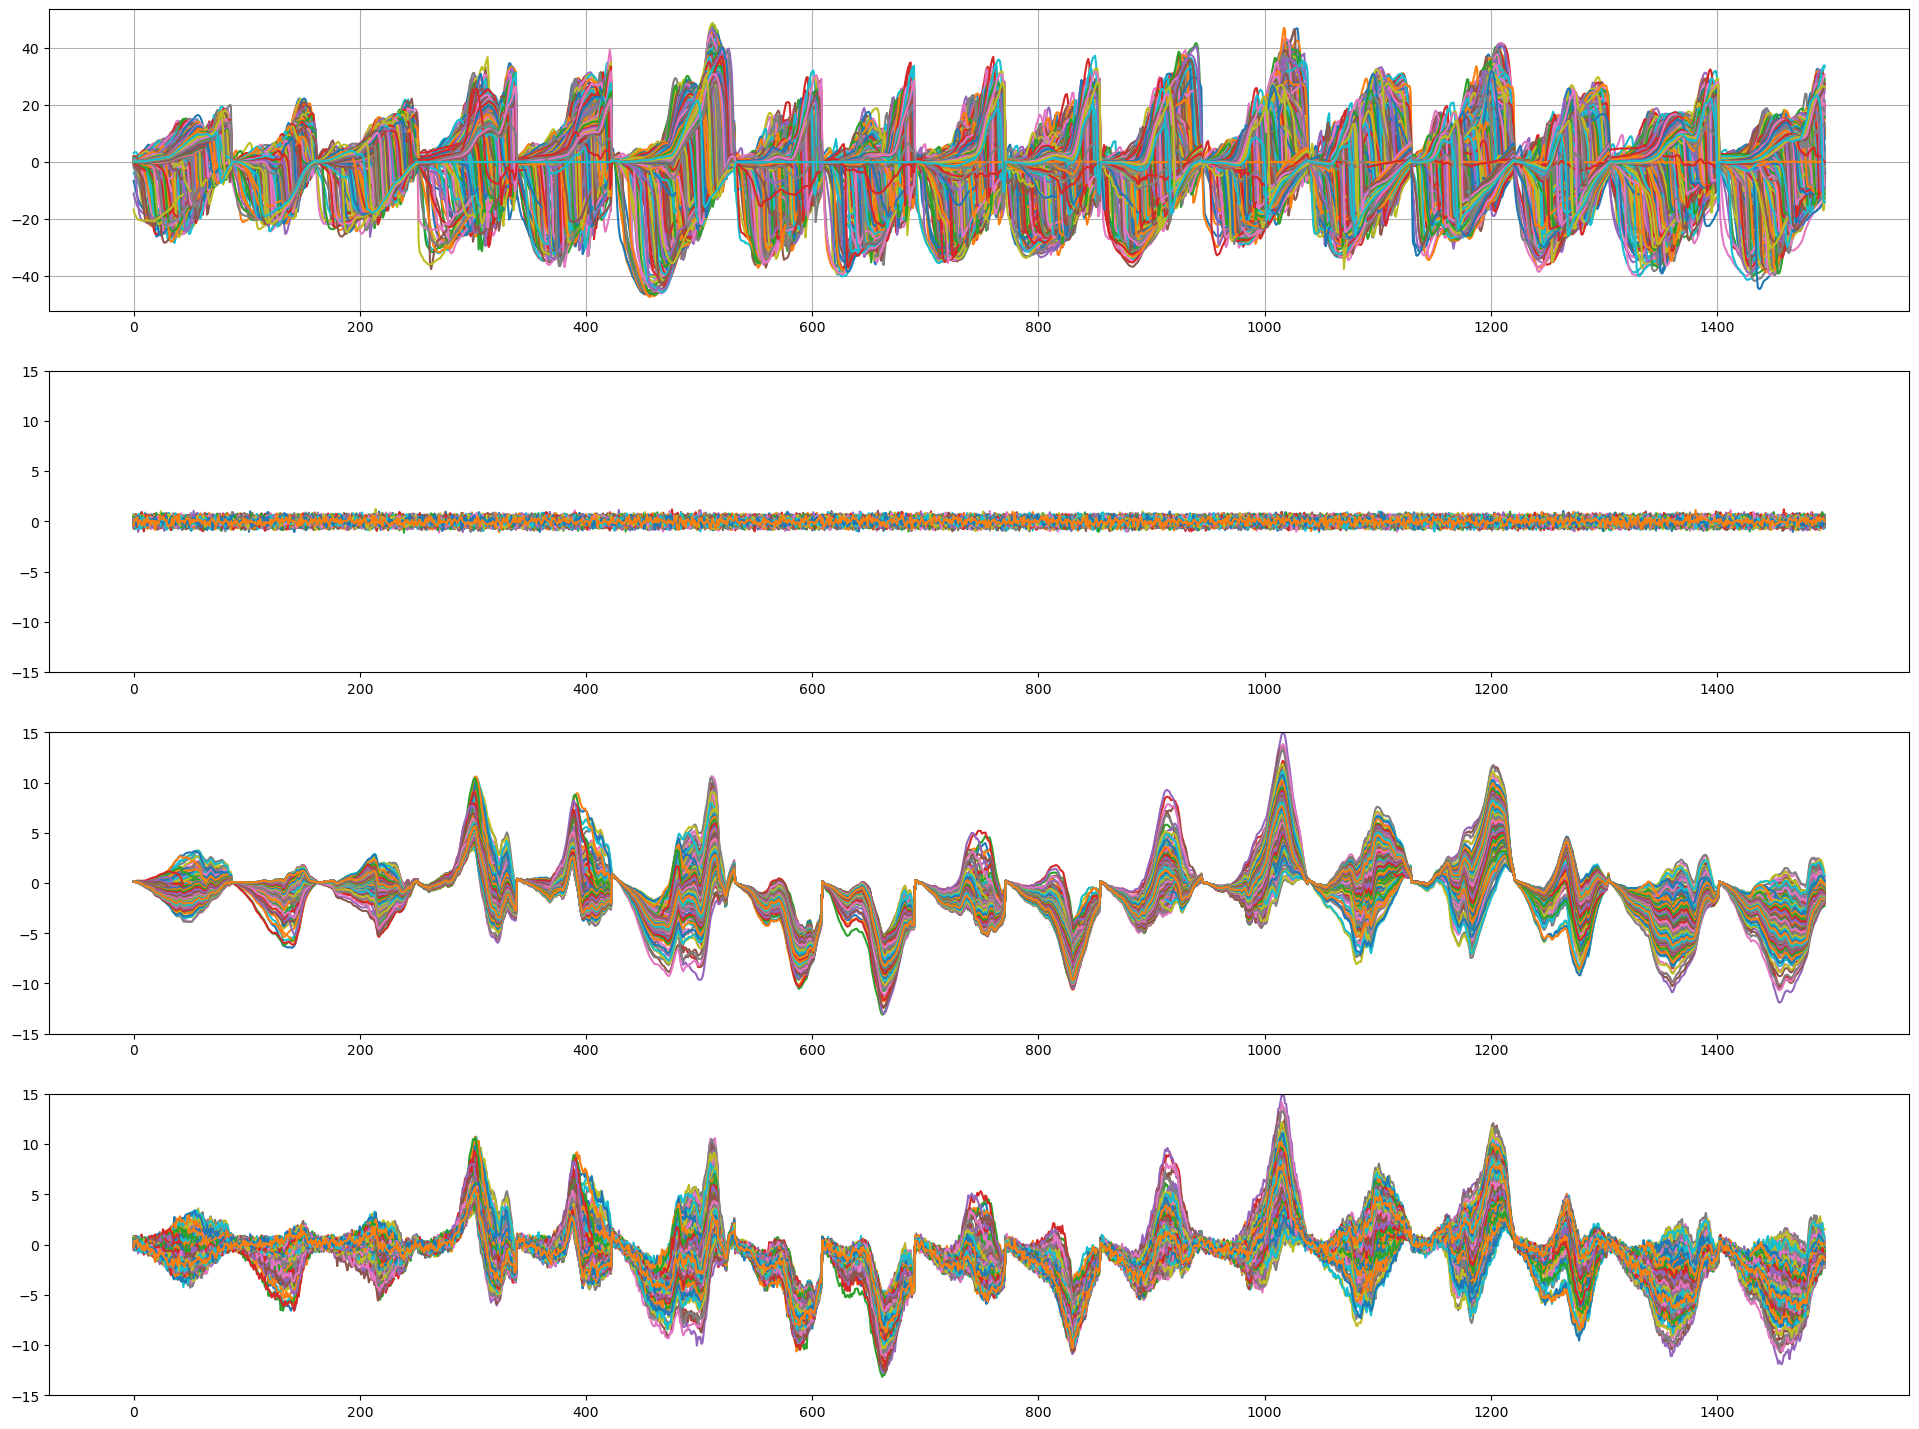

In [6]:
ylim = [-15,15]
plt.figure(figsize=(24,18))
plt.subplot(4,1,1)
plt.plot(X_test.T);
plt.grid()
Y_test_noisy,N,_ = add_noise(Y_test,20)
plt.subplot(4,1,2)
plt.plot(N.T);
plt.ylim(ylim)
plt.subplot(4,1,3)
plt.plot(Y_test.T);
plt.ylim(ylim)
plt.subplot(4,1,4)
plt.plot(Y_test_noisy.T);
plt.ylim(ylim)

# The below cell was just for the original data and is not used in anymore in ``test_model`` in [model_utils.py](model_utils.py), no need to save all of the data independetly. instead containers are saved in the loop above.

In [7]:
# np.save("test_heart_concat.npy",X_test,allow_pickle=True)
# np.save("test_torso_concat.npy",Y_test,allow_pickle=True)
# np.save("test_AT.npy",AT_test,allow_pickle=True)
# np.save("test_heart_concat_reordered.npy",X_test[node_ordering,:],allow_pickle=True)
# np.save("test_torso_concat_reordered.npy",Y_test,allow_pickle=True)
# np.save("test_AT_reordered.npy",AT_test[node_ordering,:],allow_pickle=True)
# np.save("test_data_counter.npy",test_data_counter,allow_pickle=True)


# Visualization 

In [8]:
# from models import DFBlock
# import torch
# x_hat = DFBlock(torch.from_numpy(A), torch.Tensor([1.75e-8]), torch.from_numpy(Y), torch.zeros_like(torch.from_numpy(X)), 'cpu', 1)
                   

In [9]:
# plt.subplot(2,1,1)
# plt.imshow(X[:,:100],extent=[0,1,0,1]);
# plt.title('Ground-truth')
# plt.subplot(2,1,2)
# plt.imshow(x_hat[:,:100].numpy(),extent=[0,1,0,1]);
# plt.title('Tikhonov solution')
# plt.tight_layout()